In [52]:
ColabNotebook = 'google.colab' in str(get_ipython())

if ColabNotebook:
    # monta G-drive en entorno COLAB
    from google.colab import drive
    drive.mount('/content/drive/')

    # carpeta donde se encuentran archivos .py auxiliares
    FUENTES_DIR = '/content/drive/MyDrive/Colab Notebooks/FUENTES/'
    DATOS_DIR = '/content/drive/MyDrive/Colab Notebooks/DATOS/'      # carpeta donde se encuentran los datasets
    LOCAL_DIR = './DATOS/'  # carpeta local en maquina virtual
else:
    # configuración para notebook con instalación LOCAL
    FUENTES_DIR = '../FUENTES'         # carpeta donde se encuentran archivos .py auxiliares
    DATOS_DIR   = '../DATOS/' # carpeta donde se encuentran los datasets
    LOCAL_DIR = DATOS_DIR

import os
MODELOS_DIR = os.path.abspath(DATOS_DIR+'../MODELOS/')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# agrega ruta de busqueda donde tenemos archivos .py
import sys
sys.path.append(FUENTES_DIR)

## Cargar imagenes de MNIST

In [53]:
from tensorflow import keras
import numpy as np

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_test = np.expand_dims(x_test, -1).astype("float32") / 255

## Diagrama de Autoencoder Variacional

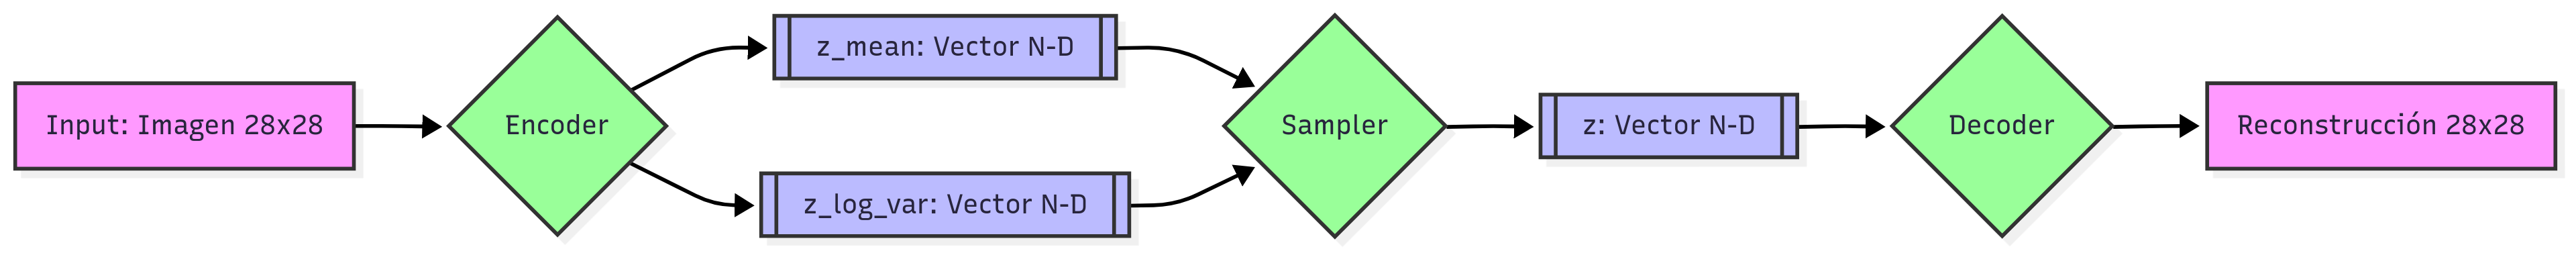

## Generación de Autoencoder Variacional con Control de Características del Espacio Latente

In [ ]:
import numpy as np
from skimage.morphology import skeletonize
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt


# Parámetros
latent_dim = 8  # 4 para atributos controlables + 4 para características latentes
image_size = 28
batch_size = 128

# # Cargar MNIST
# (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
# x_train = x_train.astype('float32') / 255.0
# x_test = x_test.astype('float32') / 255.0
# x_train = np.expand_dims(x_train, -1)
# x_test = np.expand_dims(x_test, -1)

# Función para estimar atributos (simulada - en práctica necesitarías etiquetas reales)
def estimate_attributes(images):
    """Estimación simplificada de atributos para MNIST"""
    attributes = []
    for img in images:
        img = img.squeeze()
        # Ancho: número de columnas con píxeles activos
        col_sums = img.sum(axis=0)
        width = np.count_nonzero(col_sums > 0.1) / image_size
        
        # Alto: número de filas con píxeles activos
        row_sums = img.sum(axis=1)
        height = np.count_nonzero(row_sums > 0.1) / image_size
        
        # Grosor: intensidad promedio de los píxeles activos
        #thickness = img[img > 0.1].mean() if np.any(img > 0.1) else 0

        # Esqueletización básica
        skeleton = skeletonize(img)
        thickness =  (np.sum( (img>0.1)*1 - (skeleton > 0.1)*1 )+1) / (np.sum( img>0.1 )+1)
        
        # Inclinación: diferencia entre centroides superior e inferior
        y_coords, x_coords = np.where(img > 0.1)
        if len(x_coords) > 0:
            top_half = y_coords < image_size//2
            x_centroid_top = x_coords[top_half].mean() if any(top_half) else image_size//2
            x_centroid_bottom = x_coords[~top_half].mean() if any(~top_half) else image_size//2
            angle = (x_centroid_bottom - x_centroid_top) / (image_size//2)
        else:
            angle = 0
            
        attributes.append([width, height, thickness, angle])
    
    return np.array(attributes)

# Precomputar atributos para el conjunto de entrenamiento
train_attributes = estimate_attributes(x_train)

# Clase para sampling del espacio latente
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Encoder
encoder_inputs = keras.Input(shape=(image_size, image_size, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)

z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])

encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")

# Decoder
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(7 * 7 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((7, 7, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)

decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")

# VAE con pérdida para atributos controlables
class ControlledVAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(ControlledVAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        self.attribute_loss_tracker = keras.metrics.Mean(name="attribute_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            self.attribute_loss_tracker,
        ]

    def train_step(self, data):
        images, attributes = data  # Ahora recibimos imágenes y sus atributos
        
        with tf.GradientTape() as tape:
            # 1. Paso encoder
            z_mean, z_log_var, z = self.encoder(images)
            
            # 2. Decodificar
            reconstruction = self.decoder(z)

            # 3. Cálculo de pérdida / error
            # 3.1 Pérdida de reconstrucción
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(images, reconstruction), axis=(1, 2)
                )
            )
            
            # 3.2 Pérdida KL
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            
            # 3.3 Pérdida de atributos: forzamos que las primeras 4 dimensiones correspondan a los atributos
            # Normalizamos los atributos para que estén en un rango similar
            normalized_attributes = (attributes - tf.reduce_mean(attributes, axis=0)) / tf.math.reduce_std(attributes, axis=0)
            attribute_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.mean_squared_error(normalized_attributes, z[:, :4]), 
                axis=-1)
            )
            
            # 3.4 Pérdida total
            total_loss = reconstruction_loss + kl_loss + attribute_loss

        # 5. Propagación de ajustes (Backpropagation)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        self.attribute_loss_tracker.update_state(attribute_loss)
        
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
            "attribute_loss": self.attribute_loss_tracker.result(),
        }

# Preparar datos de entrenamiento con atributos
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, train_attributes))
train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Crear y compilar el modelo
vae = ControlledVAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3))

# Entrenamiento
history = vae.fit(train_dataset, epochs=60)


Epoch 1/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 14s 13ms/step - attribute_loss: 78.5757 - kl_loss: 12.7363 - loss: 331.2356 - reconstruction_loss: 239.7329 - total_loss: 241.5962
Epoch 2/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - attribute_loss: 22.8309 - kl_loss: 14.0712 - loss: 171.4718 - reconstruction_loss: 134.5593 - total_loss: 166.6141
Epoch 3/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - attribute_loss: 18.0312 - kl_loss: 15.0649 - loss: 154.5013 - reconstruction_loss: 121.4030 - total_loss: 153.4646
Epoch 4/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - attribute_loss: 16.3199 - kl_loss: 15.0966 - loss: 149.0443 - reconstruction_loss: 117.6275 - total_loss: 148.9199
Epoch 5/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - attribute_loss: 15.3795 - kl_loss: 15.1232 - loss: 145.6928 - reconstruction_loss: 115.1908 - total_loss: 146.0042
Epoch 6/60
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - attribute_loss: 15.0315 - kl_loss: 15.1861 - loss: 143.6521 - reconstruction_loss: 113.4354 - total

### Evolución del Entrenamiento

In [ ]:
import plotly.graph_objects as go

history_dict = history.history
epochs = list(range(1, len(next(iter(history_dict.values()))) + 1))

fig = go.Figure()

for metric_name, values in history_dict.items():
    fig.add_trace(go.Scatter(
        x=epochs,
        y=values,
        mode='lines+markers',
        name=metric_name,
        line=dict(width=2),
        marker=dict(size=4)
    ))

fig.update_layout(
    title='Evolución del Entrenamiento',
    xaxis_title='Época',
    yaxis_title='Valor',
    hovermode='x unified',
    template='plotly_white',
    width=800,
    height=500
)

fig.show()

### Guarda codificador y decodificador para recrear el VAE sin entrenarlo

In [59]:
vae.encoder.save(MODELOS_DIR + 'VAE_MNIST_encoder_4d.keras')
vae.decoder.save(MODELOS_DIR + 'VAE_MNIST_decoder_4d.keras')

### Recupera codificador y decodificador para recrear el modelo VAE

In [60]:
encoder = keras.models.load_model(MODELOS_DIR + 'VAE_MNIST_encoder_4d.keras')
decoder = keras.models.load_model(MODELOS_DIR + 'VAE_MNIST_decoder_4d.keras')

vae = ControlledVAE(encoder, decoder)

## Visualización de Imágenes Generadas desde el Espacio Latante


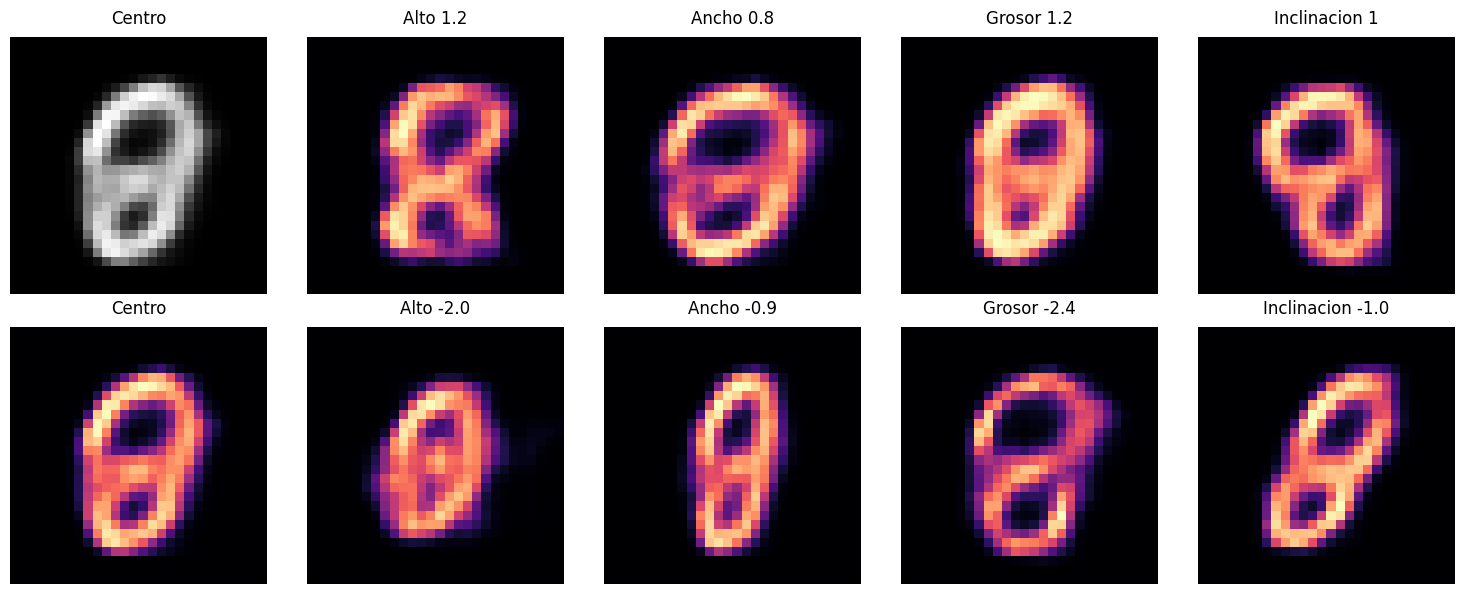

In [6]:

def generate_controlled_digit(width=0, height=0, thickness=0, angle=0):
    latent_vector = np.zeros((1, latent_dim)) # centro del espacio latente

    latent_vector[0, 0] = width
    latent_vector[0, 1] = height
    latent_vector[0, 2] = thickness
    latent_vector[0, 3] = angle

    # genera imagen directamente desde el espacio latente segun los parametros de la funcion
    generated_image = decoder.predict(latent_vector, verbose=0)[0, :, :, 0]
    
    return generated_image

def subplot_digit(rows, cols, pos, img, title='', color_map='magma'):
    plt.subplot(rows, cols, pos)
    plt.imshow(img, cmap=color_map)
    plt.title(title, pad=10)
    plt.axis('off')


# Configurar la figura
plt.figure(figsize=(15, 6))

(F, C) = (2, 5) # cantidad de filas y columnas del grafico
subplot_digit(F,C,1, generate_controlled_digit(), 'Centro', color_map='gray')
subplot_digit(F,C,2, generate_controlled_digit(height=1.2), 'Alto 1.2')
subplot_digit(F,C,3, generate_controlled_digit(width=0.8), 'Ancho 0.8')
subplot_digit(F,C,4, generate_controlled_digit(thickness=1.2), 'Grosor 1.2')
subplot_digit(F,C,5, generate_controlled_digit(angle=1.0), 'Inclinacion 1')

subplot_digit(F,C,6, generate_controlled_digit(), 'Centro')
subplot_digit(F,C,7, generate_controlled_digit(height=-2.0), 'Alto -2.0')
subplot_digit(F,C,8, generate_controlled_digit(width=-0.9), 'Ancho -0.9')
subplot_digit(F,C,9, generate_controlled_digit(thickness=-2.4), 'Grosor -2.4')
subplot_digit(F,C,10, generate_controlled_digit(angle=-1.0), 'Inclinacion -1.0')

plt.tight_layout()
plt.show()

## Visualización Controlada de Imagen Generada desde el Espacio Latante

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display

# Configuración de la interfaz en español
estilo = {'description_width': 'initial'}
disposicion = widgets.Layout(width='500px')

# Nombres para las 8 dimensiones latentes
nombres_dimensiones = [
    'Ancho', 'Altura', 'Grosor', 'Ángulo',
    'Libre 1', 'Libre 2', 'Libre 3', 'Libre 4'
]

# Crear 8 controles deslizantes (uno para cada dimensión latente)
controles = []
for i in range(8):
    control = widgets.FloatSlider(
        value=0.0,
        min=-3.0,
        max=3.0,
        step=0.1,
        description=f'{nombres_dimensiones[i]}',
        style=estilo,
        layout=disposicion
    )
    controles.append(control)

# Función para obtener un dígito aleatorio
def obtener_digito_aleatorio():
    indice = np.random.randint(0, len(x_test))
    return x_test[indice], y_test[indice]

# Cargamos un dígito aleatorio inicial
digito_original, numero = obtener_digito_aleatorio()

# Función de visualización corregida
def mostrar_transformaciones(**kwargs):
    # Extraemos los valores de los controles
    valores = [kwargs[f'{i}'] for i in range(8)]
    
    # Aplicamos las transformaciones a todas las dimensiones
    transformacion, latente_orig = apply_transformations(digito_original)
    
    # Calculamos el latente modificado
    latente_modif = latente_orig.copy()
    for i in range(8):
        latente_modif[0, i] += valores[i]
    
    # Creamos la figura
    plt.figure(figsize=(18, 6))
    
    # Mostramos el dígito original
    plt.subplot(1, 3, 1)
    plt.imshow(digito_original.squeeze(), cmap='viridis')
    plt.title(f"Dígito Original: {numero}")
    plt.axis('off')
    
    # Mostramos la transformación
    plt.subplot(1, 3, 2)
    plt.imshow(decode_latent(latente_modif), cmap='viridis')
    plt.title("Versión Transformada")
    plt.axis('off')
    
    # Mostramos todas las dimensiones latentes
    plt.subplot(1, 3, 3)
    
    # Barras para valores originales y modificados
    ancho_barra = 0.35
    posiciones = np.arange(8)
    
    plt.bar(
        posiciones - ancho_barra/2,
        latente_orig[0],
        ancho_barra,
        color='blue',
        alpha=0.7,
        label='Original'
    )
    
    plt.bar(
        posiciones + ancho_barra/2,
        latente_modif[0],
        ancho_barra,
        color='orange',
        alpha=0.7,
        label='Modificado'
    )
    
    plt.title("Espacio Latente (8 dimensiones)")
    plt.xlabel("Dimensiones")
    plt.ylabel("Valor")
    plt.ylim(-3, 3)  # Rango fijo de -3 a +3
    plt.xticks(posiciones, [f'D{i+1}' for i in range(8)], rotation=45)
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Añadir línea en y=0 como referencia
    plt.axhline(y=0, color='black', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()

# Creamos el diccionario de argumentos para interactive_output
args = {f'{i}': controles[i] for i in range(8)}

# Creamos la salida interactiva
interfaz = widgets.interactive_output(mostrar_transformaciones, args)

# Organizamos los controles en 2 filas de 4
fila_controles1 = widgets.HBox(controles[:4])
fila_controles2 = widgets.HBox(controles[4:])

# Mostramos los controles y la visualización
display(widgets.VBox([
    fila_controles1,
    fila_controles2,
    interfaz
]))
